In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from numba import njit, float64, int32
from scipy.stats import kde

plt.rcParams['figure.dpi'] = 150

import numpy.random as rng
seed = 9812631
rng.seed(seed)
@njit
def xiN(N):
    return rng.rand(N)
@njit
def xi():
    return rng.rand()
@njit
def xiNormalN(N):
    return rng.randn(N)
@njit
def xiNormal():
    return rng.randn()

Here is a simple astronomical example of using a Bayesian approach to parameter estimation using MCMC.

We will make a cartoon model of the lightcurve of a star with a transiting exoplanet. The star
has a magnitude of $M(t)$ which is constant except when eclipsed, when the brightness drops by $\Delta m$ magnitudes for some duration.

This is clearly a periodic phenomenon, but we will assume that periodicity has already been found in the
lightcurve and that a fit has been made to the period. The observation times of the lightcurve are then taken
*modulo* this period, and the data is presented as a function of the *phase* in this period.

The eclipse occurs around phase $p_e$ and lasts for $\Delta p$. There is a variance of $\sigma^2$ mag in the photometry which is constant with time.

We have
$$ M(p) = \left\{\begin{array}{ll} M-\Delta m, & p_e-\Delta p/2 < t < p_e + \Delta p/2\\ M, & \textrm{else}\end{array}\right.  + \mathcal{N}(0, \sigma)$$


Our goal is to take these data and estimate the four parameters of the model, $M$, $\Delta m$, $\Delta p$, and $p_e$, along with their uncertainties using a Bayesian approach.

Our model is

In [2]:
@njit
def modelFunction(p, w):
    M, dm, dp, pe = w
    return np.where( (p>pe-dp/2) & (p<pe+dp/2), M-dm, M)

First we generate some simulated observations 

We will use $N=100$ data points:

mu(M): 10.168801670609373  sig(M): 0.08639116633454456


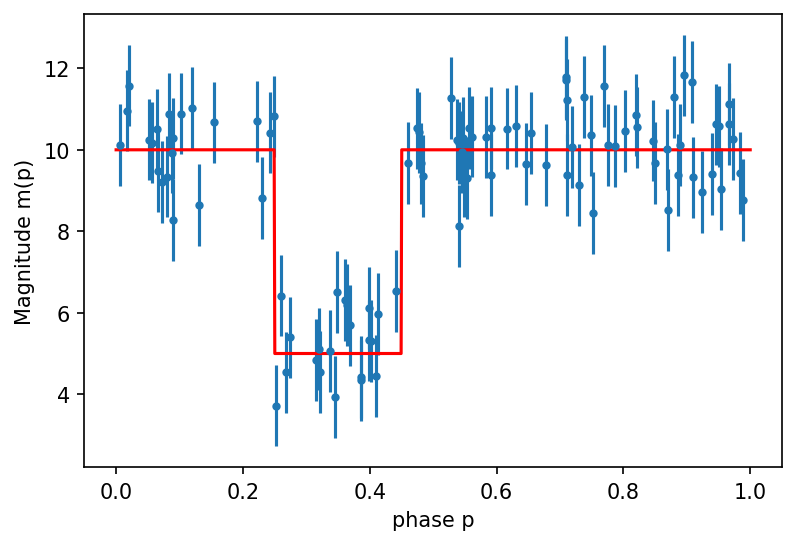

In [3]:
# Parameters for the simulated observations:
M0 = 10
dm0 = 5
dp0 = 0.2
pe0 = 0.35

# sample size:
N = 100

# variance on each observation:
sig = 1

# vector of "true" parameters
w0 = np.array([M0, dm0, dp0, pe0])

data = np.zeros((N,3))
data[:,0] = np.sort(xiN(N))
data[:,1] = modelFunction(data[:,0], w0) + sig*xiNormalN(N)
data[:,2] = np.ones(N)*sig

fig, ax = plt.subplots()
ax.errorbar(data[:,0], data[:,1], fmt='.', yerr=data[:,2])
tt = np.linspace(0,1,1000)
ax.plot(tt, modelFunction(tt, w0),'r')

ax.set_xlabel('phase p')
ax.set_ylabel('Magnitude m(p)')

# Compute sample mean and variance for M
foo = np.where( (data[:,0]>pe0-dp0/2) & (data[:,0]<pe0+dp0/2), data[:,1]+dm0, data[:,1])
muM0 = np.sum(foo)/N
sigM0 = np.sqrt( (np.sum(foo**2)/N - muM0**2)/(N-1))
print(f"mu(M): {muM0}  sig(M): {sigM0}")


We want to calculate the posterior distributions of the parameters $\mathbf{w} = \left\{M, \Delta m, \Delta p, p_e\right\}$ given some prior distribution on the parameters $p(\mathbf{w})$:   

$$ p(\mathbf{w}|D) = \frac{p(D|\mathbf{w}) p(\mathbf{w})}{p(D)} $$

For the *a priori* distribution $p(D|\mathbf{w})$, we will assume that the data have some variance associated with a single measurement, $\sigma^2$ and fit to the same function of four parameters we used to generate the fake data
$$ M(p) = \left\{\begin{array}{ll} M-\Delta m, & p_e-\Delta p/2 < t < p_e + \Delta p/2\\ M, & \textrm{else}\end{array}\right. $$
Generating simulated data from your model and then recovering parameters is often quite useful in refining your data analysis approach.

Assuming normally-distributed errors in the individual measurements, the likelihood of the data then becomes
$$ p(D|\mathbf{w}) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi}\sigma_i} \exp\left\{-\frac{1}{2}\frac{ \left(m_i - m(p_i)\right)^2 }{\sigma_i^2}\right\} $$   

As usual, we will compute using the log of the likelihood
$$ \log p(D|\mathbf{w}) = -\frac{N}{2}\log(2\pi) - \sum_{i=1}^N \log(\sigma_i) - \frac{1}{2}\sum_{i=1}^N \frac { \left(m_i - m(p_i)\right)^2 }{\sigma_i^2} $$

Our likelihood function is then

In [4]:
@njit
def logLikelihood(data, w):
    """
    Log of the likelihood given the parameters
    data[:,0] = the observed phase
    data[:,1] = the observed magnitude
    data[:,2] = the reported error in the individual observations
    """
    N = data.shape[0]
    return -0.5*N*np.log(2*np.pi) - np.log(data[:,2]).sum() \
           - 0.5*np.sum( (data[:,1] - modelFunction(data[:,0],w))**2 / data[:,2]**2 )

Next we need to specify a prior distribution on each of the parameters in $\mathbf{w}$. While the details of the experimental methods and other information might well lead to correlation between parameters, we will make the simplest assumption, that our priors for each of the four parameters are independent. This is usually a good way to begin an analysis. Subsequently, as one learns more about the system, one can refine one's priors accordingly.

Thus our overall prior distribution becomes the product of the priors on each of the four parameters:
$$ p(\mathbf{w}) = \prod_{i=1}^4 p(w_i) $$

We'll make some very simple assumptions, that each of the parameters has an equal likelihood of taking on a value in some range. That is, that they are drawn from a uniform distribuition over some range of values. The prior on
$M$ is simply some large range. It makes no sense in our model for $\Delta m$ to be less than zero, or for $p_e$ and $\Delta p$ to be outside the range $[0,1)$. We'll take
\begin{split}
p(M) &= U(-100,100) \\
p(\Delta m) &= U(0,10) \\
p(\Delta p) &= U(0,1) \\
p(p_e) &= U(0,1)
\end{split}
where $U(a,b)$ is the uniform distribution on $[a,b)$. Note that we won't need to normalize $p(\mathbf{w})$ since we will be using the Metropolis algorithm.

(As an example of a slightly more complicated prior, we could have made our prior on $\Delta m$ depend upon $M$ by requiring $M-\Delta m > \min(M)$)

Here is a function reporting the log prior. It return zero ($\log(1)$) if all parameters are in range, and $-\infty$ otherwise. (There is no significance to $-\infty$ here; it is simply used as a flag.)

In [5]:
# Ranges in parameter values:
wRange = np.array([[-100,100],[0, 10], [0, 1], [0, 1]])

@njit
def logPrior(w):
    
    for i in range(w.shape[0]):
        if (w[i] < wRange[i,0]) or (w[i] > wRange[i,1]):
            return -np.Inf
    return 0.0

and a function to sample from the prior distribution

In [6]:
@njit
def samplePrior():
    nParams = wRange.shape[0]
    w = np.zeros(nParams)
    for i in range(nParams):
        w[i] = (wRange[i,1]-wRange[i,0])*xi() + wRange[i,0]
    
    return w

Our problem is to determine an approximation to the posterior distribution $p(\mathbf{w}|D)$. From this we can determine the most probable value of $\mathbf{w}$ and some sense of the uncertainties. We can also determine the
marginal posterior distribution of each of the parameters $w_i$   

$$ p(w_i) = \int\cdots\int p(\mathbf{w}|D)\ \left(\prod_{\substack{j=1\\j\ne i}}^4 dw_j\right) $$

We *could* approach this problem by making grids covering the range in each of the components. An approximation to $p(\mathbf{w}|D)$ would then come from computing the likelihood in each grid cell. More likely than not, the data in most of our cells would not contribute very much to our understanding of $p(\mathbf{w}|D)$. We would also be limited in the resolution of our method to some fraction of the grid spacing. As the dimension (number of parameters) increases, the size of our grid could become very large indeed.

A better way is to generate samples from $p(\mathbf{w}|D)$. These will have greater frequency near the peak of the distribution and will thus concentrate resolution where we need it most. As we have seen, MCMC is a useful way to
generate these samples.

To implement MCMC, we will need to generate proposed moves in the random walk. If the walk is currently at
$\mathbf{w}_i$, we need a probability distribution from which to sample the proposed next location.
MCMC is quite sensitive to the width of the proposal distribution. If it is too wide, almost all of the proposed moves will be rejected. The efficiency will be very poor and we will need to propose an enormous number of moves to explore the distribution. If the distribution of proposed moves is too small, most of them will be accepted, but it will again take a very long time to move very far in parameter space. It is often suggested that a distribution which results in $\approx50\%$ of the moves being accepted is near optimum.

Much of the art in MCMC comes into play in crafing an efficient scheme for proposing moves. For this example, we will draw our moves from a distribution peaked at fairly small values, but with "fat tails", ensuring that we can efficiently (to some extent at least) move throughout the parameter space.

One way to do this is to sample from a mixture of Gaussians. Our algorithm will be to sample the variance from
a uniform distribution, and then then sample from a normal distribution with that variance. This is much like sampling from a power-law, but with a smooth cutoff.

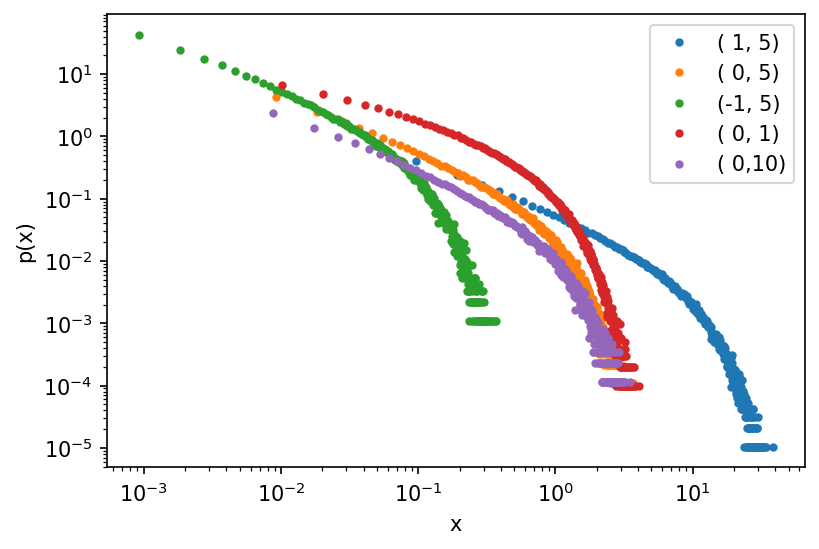

In [7]:
@njit
def sampleMixture(a, b):
    return 10.0**(a - b*np.abs(xiNormal()/np.sqrt(-np.log(xi()))))*xiNormal()

N = 1000000
def getmix(N, a, b):
    x = np.zeros(N)
    for i in range(N):
        x[i] = sampleMixture(a, b)
    return np.abs(x)


fig, ax = plt.subplots()
x = getmix(N, 1, 5)
hist, edges = np.histogram(x, bins=400, density=True)
ax.loglog(edges[1:-1], hist[1:], '.', label='( 1, 5)')

x = getmix(N, 0, 5)
hist, edges = np.histogram(x, bins=400, density=True)
ax.loglog(edges[1:-1], hist[1:], '.', label='( 0, 5)')

x = getmix(N, -1, 5)
hist, edges = np.histogram(x, bins=400, density=True)
ax.loglog(edges[1:-1], hist[1:], '.', label='(-1, 5)')

x = getmix(N, 0, 1)
hist, edges = np.histogram(x, bins=400, density=True)
ax.loglog(edges[1:-1], hist[1:], '.', label='( 0, 1)')

x = getmix(N, 0, 10)
hist, edges = np.histogram(x, bins=400, density=True)
ax.loglog(edges[1:-1], hist[1:], '.', label='( 0,10)')

ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.legend();

Of course, the size of the jump in each parameter should vary with the scale of the parameter range, so
our proposal function will be

In [8]:
@njit("float64[:](float64[:])")
def propose(w: np.ndarray) -> np.ndarray:
    nParam = w.shape[0]
    wNew = np.zeros_like(w, dtype=np.float64)
    wNew[:] = w

    # Which one should we change?
    i = int(xi()*nParam)
    eps = sampleMixture(1,3.0)
    wNew[i] += (wRange[i,1]-wRange[i,0])*eps
        
    return wNew

We are now ready to write our MCMC sampling function:

In [9]:
@njit
def MCMC(Nsteps, data):
    
    
    # start off at some random w drawn from our prior distribution
    w = samplePrior()
    logp, logl = logPrior(w), logLikelihood(data, w)
    
    nParam = w.shape[0] # the value of w plus its likelihood
    chain = np.zeros((Nsteps, nParam + 1))

    # count the number of successful proposals
    ngood = 0
    
    for i in range(Nsteps):
        wNew = propose(w)
        logpNew = logPrior(wNew)

        # Only evaluate the likelihood if prior prob isn't zero
        loglNew = -np.Inf
        if logpNew != -np.Inf:
            loglNew = logLikelihood(data, wNew)
            
        # Log of acceptance ratio p(D|wNew)p(wNew) / ( p(D|w)p(w) )
        logRatio = (logpNew + loglNew) - (logp + logl)
        logRatio = min(0.0, logRatio)

        # Acceptance/rejection
        if xi() <= np.exp(logRatio):
            w = wNew
            logp = logpNew
            logl = loglNew
            ngood += 1

        chain[i, :-1] = w
        chain[i, -1] = logl

    return chain, ngood/Nsteps

Try running a chain.

In [10]:
N = 10**6
chain, goodFrac = MCMC(N, data)

print(f"\n\nAcdeptance ratio: {goodFrac}")



Acdeptance ratio: 0.398074


In [11]:
chain[:,-1]

array([-38854.43905773, -38854.43905773, -38854.43178555, ...,
         -128.74418368,   -128.74418368,   -128.74418368])

Plot the MCMC chain for each of the parameters. 

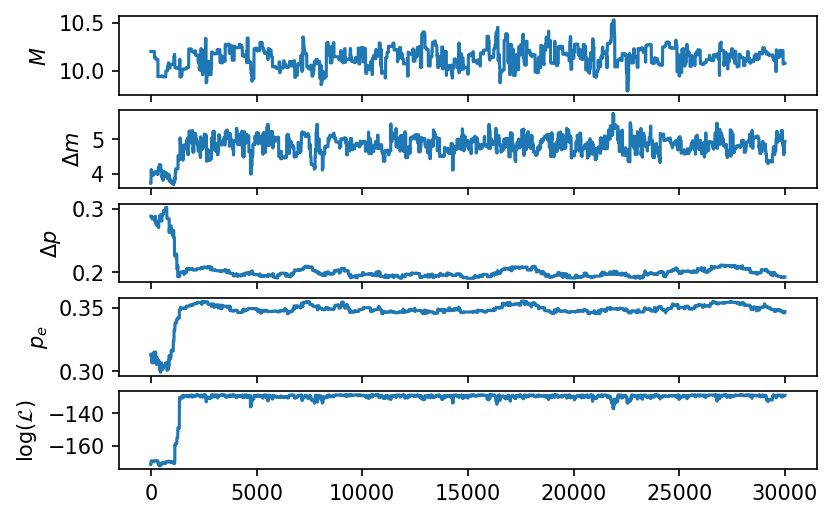

In [12]:
burn = 500
end = burn + 3*10**4

M  = chain[burn:end,0]
dm = chain[burn:end,1]
dp = chain[burn:end,2]
pe = chain[burn:end,3]
ll = chain[burn:end,4]

fig, ax = plt.subplots(5, 1, sharex=True)
ax[0].plot(M)
ax[0].set_ylabel(r'$M$')

ax[1].plot(dm)
ax[1].set_ylabel(r'$\Delta m$')

ax[2].plot(dp)
ax[2].set_ylabel(r'$\Delta p$')

ax[3].plot(pe)
ax[3].set_ylabel(r'$p_e$')

ax[4].plot(ll)
ax[4].set_ylabel(r'$\log(\mathcal{L})$');

samples = chain[burn:,:]

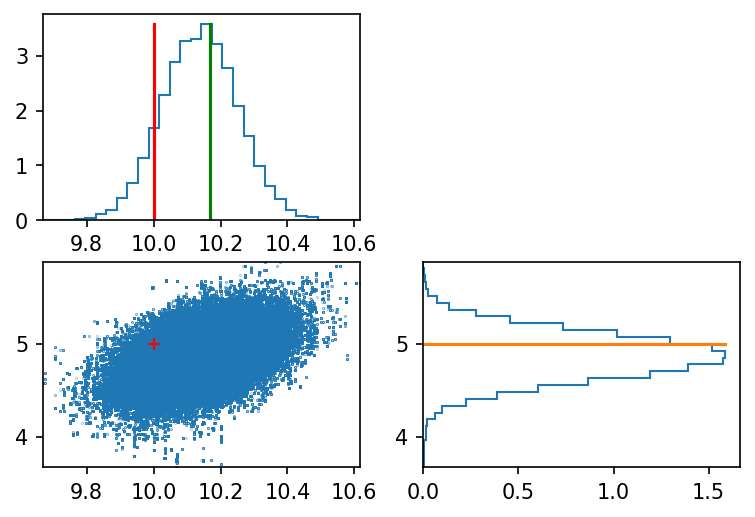

In [13]:
M = samples[:,0]
dm = samples[:,1]

fig, ax = plt.subplots(2, 2)
hts, edges, pat = ax[0,0].hist(M,bins=30, density=True, histtype='step')
ax[0,0].set_xlim(M.min(), M.max())
ax[0,0].plot([w0[0],w0[0]], [hts.min(),hts.max()],'r')
ax[0,0].plot([muM0,muM0], [hts.min(),hts.max()], 'g')

ax[0,1].remove()

ax[1,0].scatter(M, dm, marker='.', s=0.1)
ax[1,0].set_ylim(dm.min(), dm.max())
ax[1,0].set_xlim(M.min(), M.max())
ax[1,0].set_ylim(dm.min(), dm.max())
ax[1,0].plot(w0[0], w0[1],'r+')

hts, edges, pat = ax[1,1].hist(dm, bins=30, density=True, orientation='horizontal', histtype='step')
ax[1,1].set_ylim(dm.min(), dm.max());
ax[1,1].plot([hts.min(),hts.max()], [w0[1],w0[1]])

One traditional way of displaying the results of such a simulation is the "corner plot": a triangular array of plots showing the 

/home/pinto/Teaching/513/Week10/pygtc.py:1261: UserWarning: No contour levels were found within the data range.
  ax.contour(plotData[nChains-1-k],


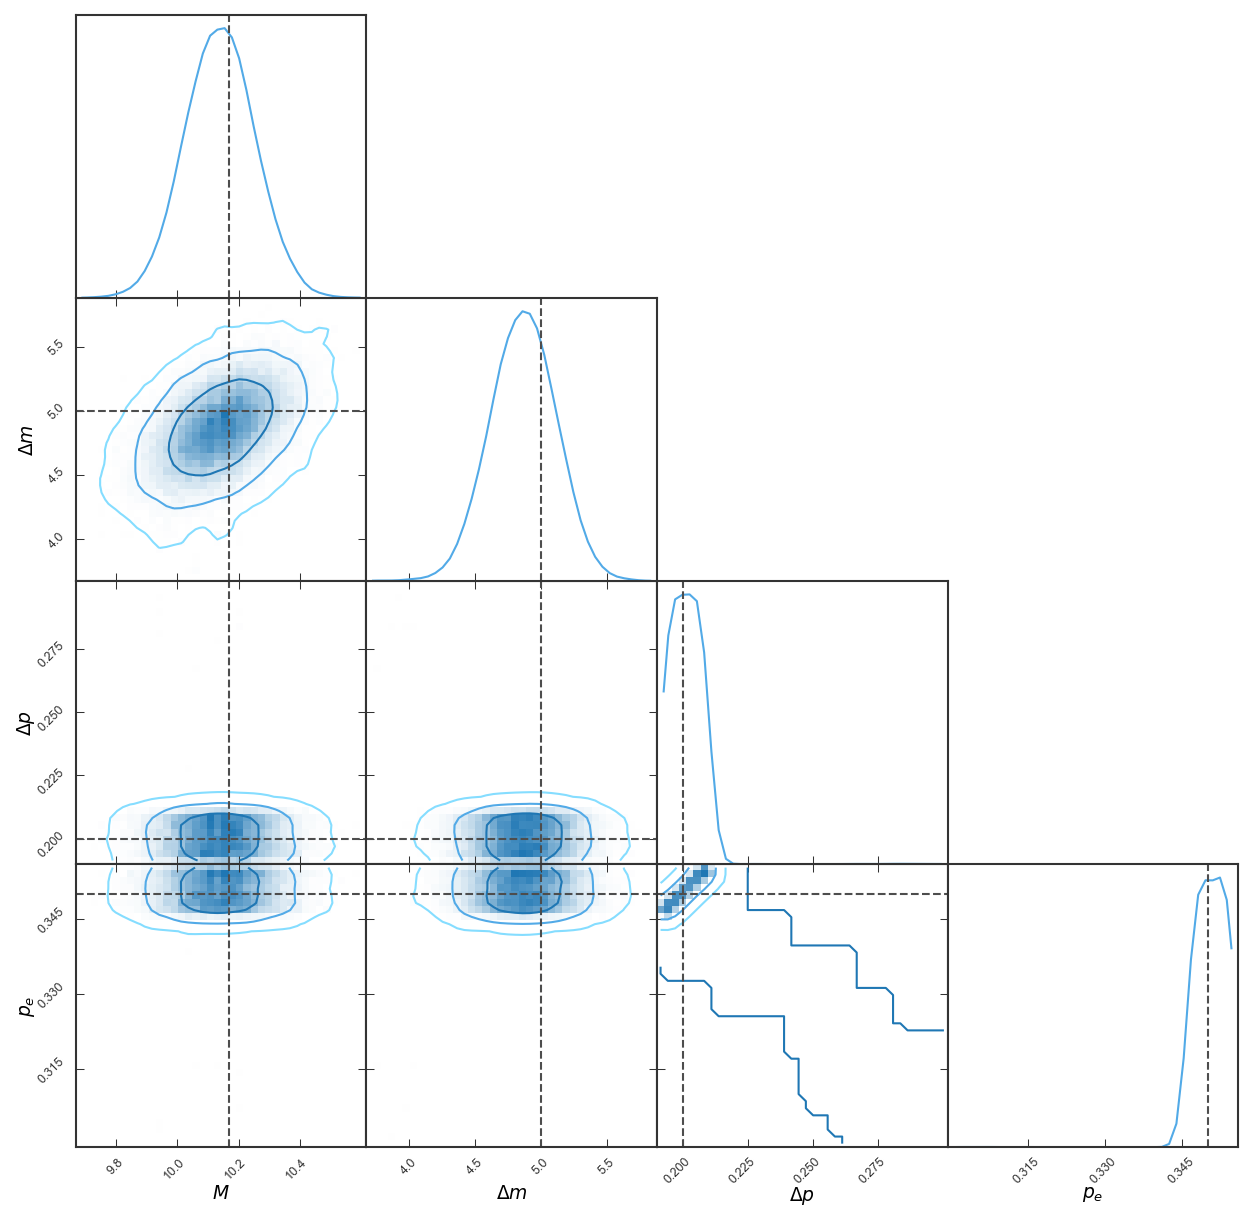

In [14]:
import pygtc
pygtc.plotGTC(chains=[samples[:,:-1]],
              paramNames=['$M$','$\Delta m$','$\Delta p$','$p_e$'],
              truths=[muM0, 5, 0.2, 0.35],
              nBins=40,
              smoothingKernel=1,
              nContourLevels=3,
              filledPlots=False,
              plotDensity=True,
              figureSize=10);

One "problem" with MCMC is that, while the chain samples the distribution function as advertised (after some burn-in), it produces samples which are correlated. We can look at this by computing the *autocorrelation function*. For a discrete random process $X_i$ with known mean $\mu$ and variance $\sigma^2$, the autocorellation at *lag* $k$ is   

$$ R(k) = \frac{1}{(N-k)\sigma^2}\sum_{i=1}^{N-k} (X_i - \mu)(X_{i+k}-\mu) $$

Let's compute this for the result of our MCMC calculation

In [15]:
def autocorrelate(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    size=2*n-1
    
    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp, size)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

Text(0, 0.5, 'P(k)')

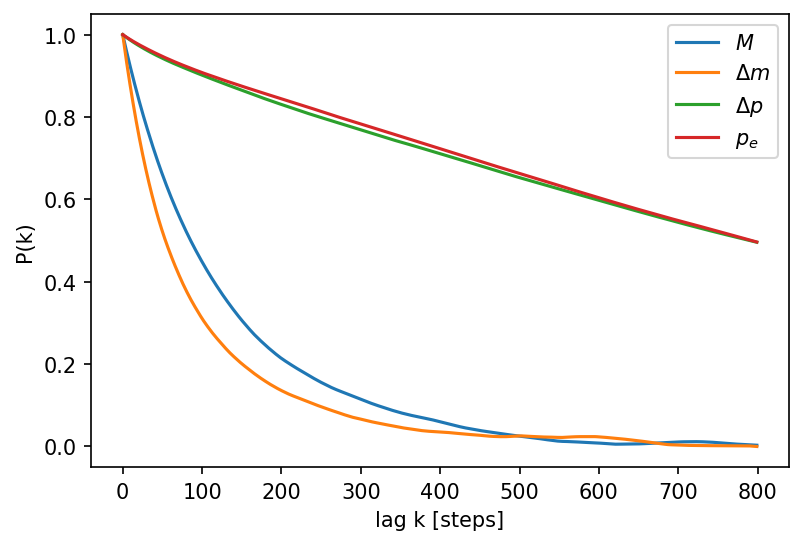

In [16]:
lags = range(0,800)

end = -1

fig, ax = plt.subplots()
result = autocorrelate(chain[burn:end,0],lags)
ax.plot(result, label='$M$')
result = autocorrelate(chain[burn:end,1],lags)
ax.plot(result, label='$\Delta m$')
result = autocorrelate(chain[burn:end,2],lags)
ax.plot(result, label='$\Delta p$')
result = autocorrelate(chain[burn:end,3],lags)
ax.plot(result, label='$p_e$')
ax.legend()
ax.set_xlabel('lag k [steps]')
ax.set_ylabel('P(k)')

We can see that there is substantial correlation in the sequences until a lag of about 800. Thus, taking every 800-th sample will get us uncorrelated samples. This is an indication that the Markov chain takes about 800 steps to "mix". Next time we will look at ways to increase the efficiency of MCMC sampling.

The result of MCMC is a "point cloud", a set of samples in $n_{params}$-dimensional space. The approximation to the probability density we seek, $p(\mathbf{w}|D)$, is the density of points.

So far, we have use histograms to estimate the density, but histograms have some of the same problems as gridding the parameter space. The resolution is determined by the bin size, which is usually constant.

A more effective way of estimating density is *kernel density estimation* (KDE), where a kernel function $K$ is used to determine the density as (in 1D):   

$$ \rho(x)_h = \frac{1}{nh} \sum_{i=1}^N K(\frac{x-x_i}{h}) $$

Here $h$ is a length scale which is adaptively changed, e.g. to keep the same number of points $n<<N$ within
the kernel.

In [ ]:
nbins = 300
M = samples[:10**4,0]
dm = samples[:10**4,1]

kernel = kde.gaussian_kde([M,dm])
nbins = 300
xi, yi = np.mgrid[M.min():M.max():nbins*1j, dm.min():dm.max():nbins*1j]
zi = kernel(np.vstack([xi.flatten(), yi.flatten()])).reshape(xi.shape)

fig, ax = plt.subplots(2,1)
ax[0].scatter(M, dm, c=kernel(np.vstack([M,dm])), s=0.1)
